In [ ]:
# caracteristicas de las imágenes
dataset_eda = r"C:\Users\npere\OneDrive\Desktop\Universidad_La_Salle\Clases\Semestre_2\Herramientas_avanzadas_de_análisis_de_datos\Proyecto_final\dataset\affectnet"

# 1. Importación y configuración de entorno

## Carga librerías

In [ ]:
import os
import time
import shutil
import random
from collections import Counter

import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import dlib
import cv2

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler


## Selección de dispositivo

In [4]:
# Configuramos el dispositivo: usamos GPU si está disponible, sino se utiliza la CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cpu


# 1. EDA

In [6]:
# Mostramos la estructura del dataset (lista de clases) para verificar la organización
dataset_full = datasets.ImageFolder(root=dataset_eda, transform=transforms.ToTensor())
print("Clases encontradas en el dataset:", dataset_full.classes)

Clases encontradas en el dataset: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


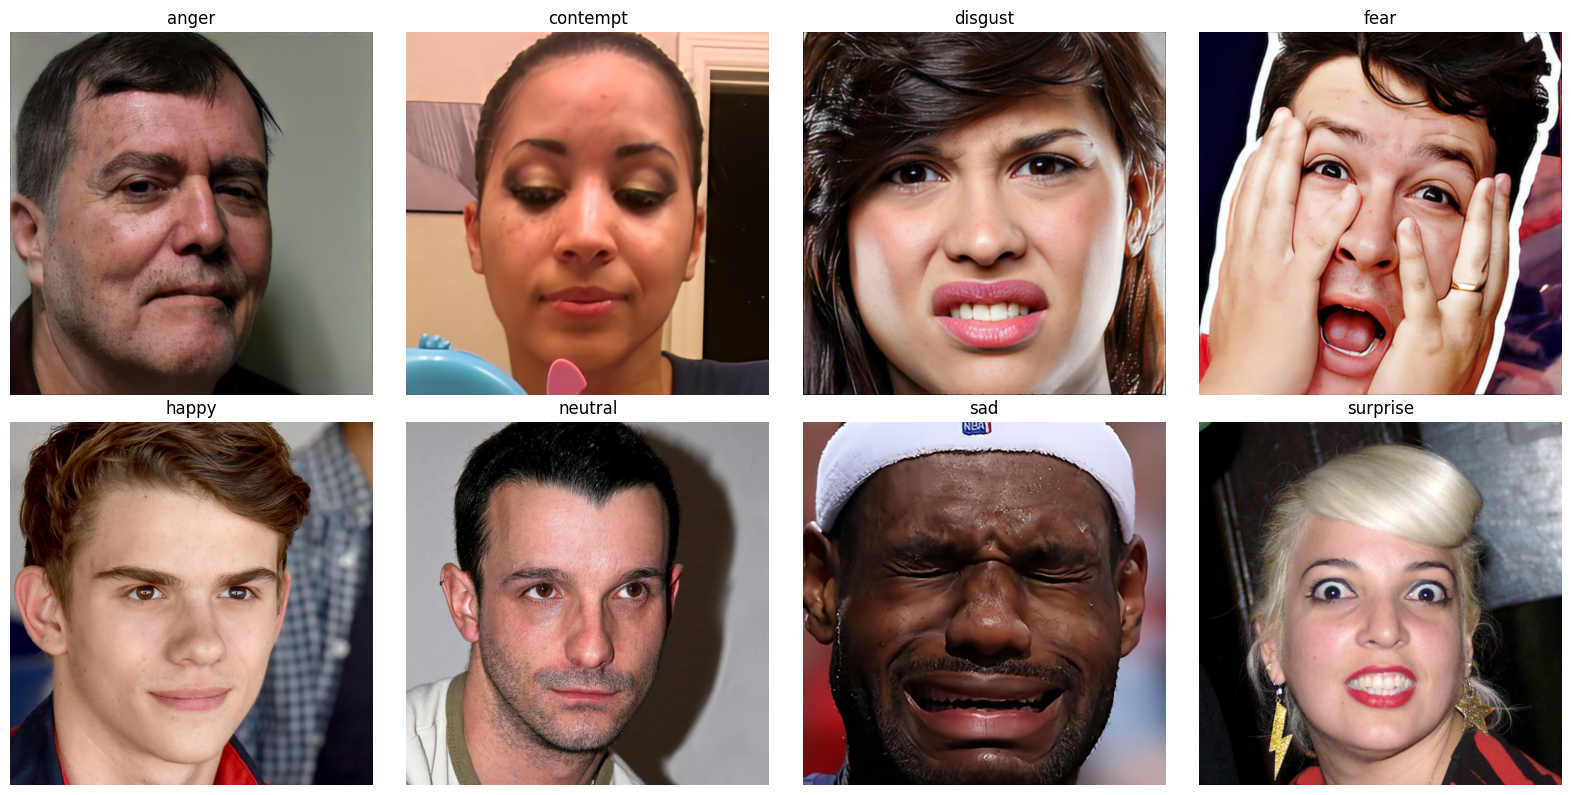

In [11]:
# Clases específicas que deseas visualizar
clases_a_mostrar = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Crear una figura
plt.figure(figsize=(16, 8))

for idx, clase in enumerate(clases_a_mostrar):
    if clase in dataset_full.class_to_idx:
        class_idx = dataset_full.class_to_idx[clase]
        
        # Filtrar todas las imágenes que pertenecen a esa clase
        imagenes_de_clase = [img_path for img_path, label in dataset_full.samples if label == class_idx]
        
        if imagenes_de_clase:
            # Elegir una imagen aleatoria
            ruta_aleatoria = random.choice(imagenes_de_clase)
            imagen = Image.open(ruta_aleatoria).convert("RGB")
            
            plt.subplot(2, 4, idx + 1)
            plt.imshow(imagen)
            plt.title(clase)
            plt.axis('off')
        else:
            print(f"⚠️ No se encontraron imágenes para la clase: {clase}")
    else:
        print(f"⚠️ Clase '{clase}' no encontrada en el dataset.")

plt.tight_layout()
plt.show()

## Caracterisiticas de las imagenes

In [37]:
widths, heights = [], []  # Listas para almacenar los anchos y altos de las imágenes

# Recorre todas las carpetas y archivos dentro de 'dataset_eda'
for root, _, files in os.walk(dataset_eda):
    for file in files:
        # Verifica que el archivo sea una imagen con extensión válida
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            path = os.path.join(root, file)  # Construye la ruta completa del archivo
            try:
                img = Image.open(path)  # Abre la imagen
                widths.append(img.width)   # Guarda el ancho
                heights.append(img.height)  # Guarda el alto
            except:
                continue  # Si hay error al abrir la imagen, la salta

print(f"Tamaño promedio: {sum(widths)/len(widths):.1f} x {sum(heights)/len(heights):.1f}")
print(f"Rango de tamaños: ancho ({min(widths)}–{max(widths)}), alto ({min(heights)}–{max(heights)})")


Tamaño promedio: 840.0 x 840.0
Rango de tamaños: ancho (268–3893), alto (268–3893)


In [38]:
# Inicialización
data = []  # Lista donde se almacenará cada imagen como diccionario con imagen, etiqueta y ruta
max_images = 31002  # Límite máximo de imágenes a cargar
count = 0  # Contador de imágenes cargadas
t0 = time.time()  # Marca de tiempo para calcular duración del proceso

# Lista de carpetas (clases)
classes = sorted([d for d in os.listdir(dataset_eda) if os.path.isdir(os.path.join(dataset_eda, d))])
# Obtiene todas las carpetas dentro de 'dataset_eda', que representan las clases

# Carga de imágenes
for label in classes:
    class_dir = os.path.join(dataset_eda, label)  # Ruta de la carpeta de la clase actual
    files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    # Lista de archivos de imagen válidos dentro de la clase

    for file in files:
        img_path = os.path.join(class_dir, file)  # Ruta completa de la imagen
        try:
            img = Image.open(img_path).convert("RGB").resize((224, 224))  # Abre y redimensiona la imagen a 224x224
            img_np = np.array(img)  # Convierte la imagen a arreglo NumPy
            data.append({
                "image": img_np,     # Imagen en formato array
                "label": label,      # Clase de la imagen
                "path": img_path     # Ruta original del archivo
            })
            count += 1  # Aumenta el contador de imágenes

            if count % 1000 == 0:
                print(f"{count} imágenes cargadas...")  # Mensaje de progreso cada 1000 imágenes

            if count >= max_images:
                break  # Finaliza si se alcanza el máximo de imágenes
        except Exception as e:
            continue  # Si ocurre un error con una imagen, se salta

    if count >= max_images:
        break  # También rompe el bucle exterior si se alcanza el límite

# Crear DataFrame
df = pd.DataFrame(data)  # Crea un DataFrame con la información cargada

# Tiempo total
t1 = time.time()
tiempo_total = round(t1 - t0, 2)  # Calcula el tiempo total de ejecución

# Resultados
print(f"\n Total de imágenes cargadas: {len(df)}")
print(f" Tiempo total: {tiempo_total} segundos")

1000 imágenes cargadas...
2000 imágenes cargadas...
3000 imágenes cargadas...
4000 imágenes cargadas...
5000 imágenes cargadas...
6000 imágenes cargadas...
7000 imágenes cargadas...
8000 imágenes cargadas...
9000 imágenes cargadas...
10000 imágenes cargadas...
11000 imágenes cargadas...
12000 imágenes cargadas...
13000 imágenes cargadas...
14000 imágenes cargadas...
15000 imágenes cargadas...
16000 imágenes cargadas...
17000 imágenes cargadas...
18000 imágenes cargadas...
19000 imágenes cargadas...
20000 imágenes cargadas...
21000 imágenes cargadas...
22000 imágenes cargadas...
23000 imágenes cargadas...
24000 imágenes cargadas...
25000 imágenes cargadas...
26000 imágenes cargadas...
27000 imágenes cargadas...
28000 imágenes cargadas...
29000 imágenes cargadas...
30000 imágenes cargadas...
31000 imágenes cargadas...

 Total de imágenes cargadas: 31002
 Tiempo total: 1033.81 segundos


In [39]:
# Revisar las dimensiones de las imágenes en df
alturas = []
anchos = []

for img in df["image"]:
    alturas.append(img.shape[0])
    anchos.append(img.shape[1])

# Verificamos si todas tienen tamaño 224x224
unicos_altos = set(alturas)
unicos_anchos = set(anchos)

print(f"Alturas únicas encontradas: {unicos_altos}")
print(f"Anchos únicos encontrados: {unicos_anchos}")

if unicos_altos == {224} and unicos_anchos == {224}:
    print(" TODAS las imágenes fueron transformadas a 224x224 correctamente.")
else:
    print(" Hay imágenes con tamaños distintos a 224x224.")

Alturas únicas encontradas: {224}
Anchos únicos encontrados: {224}
 TODAS las imágenes fueron transformadas a 224x224 correctamente.


## Distribución de las Clases

In [40]:
# Visualización de la distribución de clasesy detectar desbalanceo en las clases

# Obtener las etiquetas desde el DataFrame ya cargado
labels = df['label'].tolist()

# Contar las ocurrencias por clase
class_counts = Counter(labels)

# se crea una nueva base de datos con las clases y la cantidad de imágenes por clase
df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Cantidad'])
df_counts.index.name = 'Clase'
df_counts.reset_index(inplace=True)

# porcentaje
total = df_counts['Cantidad'].sum()
df_counts['Porcentaje (%)'] = (df_counts['Cantidad'] / total * 100).round(2)

print(df_counts)

      Clase  Cantidad  Porcentaje (%)
0     anger      3638           11.73
1  contempt      3179           10.25
2   disgust      2660            8.58
3      fear      3622           11.68
4     happy      5045           16.27
5   neutral      5132           16.55
6       sad      3430           11.06
7  surprise      4296           13.86


In [43]:
# df_counts = dataframe con conteo de cada clase
max_count = df_counts['Cantidad'].max()
min_count = df_counts['Cantidad'].min()
ratio = max_count / min_count

print(f"Ratio entre la clase más común y la menos común: {ratio:.2f}")


Ratio entre la clase más común y la menos común: 1.93


Interpretación del umbral:

* IR = 1 → Conjunto perfectamente balanceado.

* 1 < IR < 2 → Leve desbalance (normalmente aceptable). 1.93

* IR ≥ 2 → Desbalance relevante (puede afectar al modelo).

Este umbral está respaldado por el criterio convencional descrito en la literatura, donde se considera que un IR ≥ 2 puede indicar un conjunto desbalanceado, tomando en cuenta la naturaleza del problema (Dialéktico, 2024 https://dialektico.com/datos-desbalanceados-definicion-ejemplos/?utm_source=chatgpt.com).

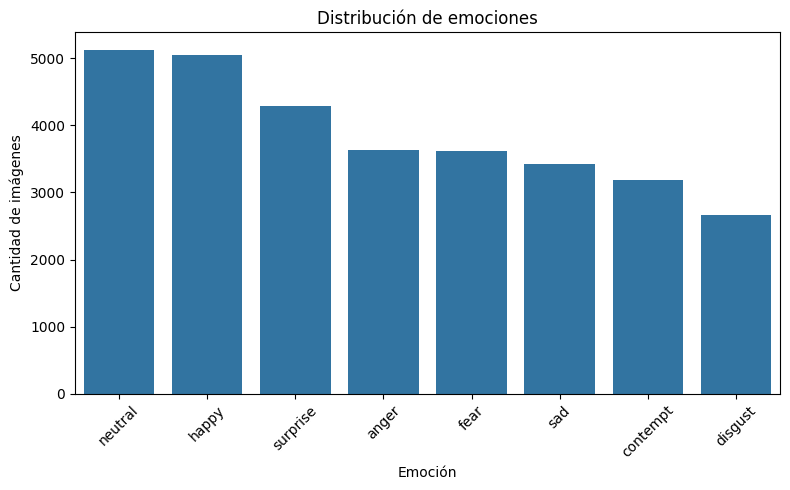

In [44]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
plt.title("Distribución de emociones")
plt.xlabel("Emoción")
plt.ylabel("Cantidad de imágenes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analisis R.G.B

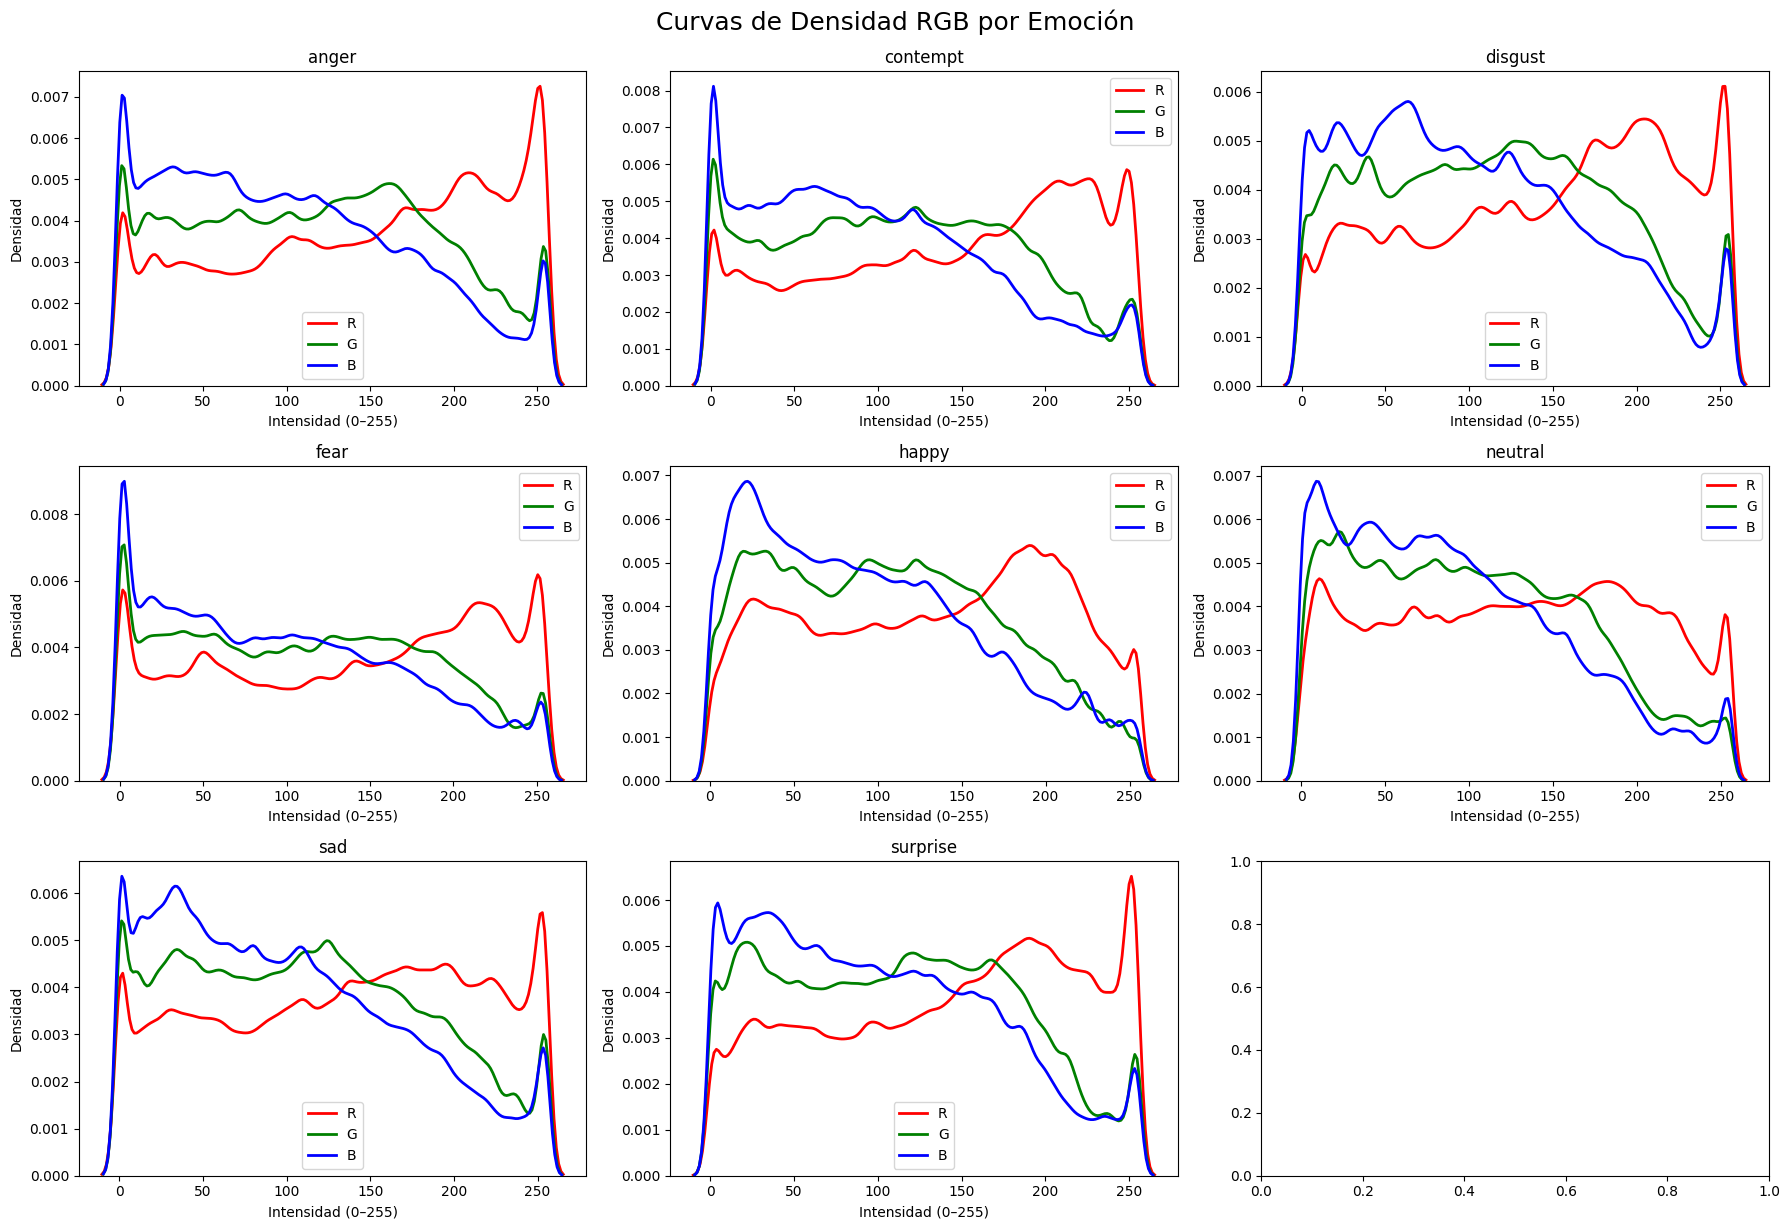

In [ ]:
# Obtener todas las emociones únicas del DataFrame y ordenarlas alfabéticamente
emociones = sorted(df['label'].unique())

# Crear una figura de 3x3 subplots (una por cada emoción)
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()  # Convertir matriz 3x3 de ejes en una lista plana para iterar fácilmente

# Iterar sobre cada emoción para graficar su distribución RGB
for i, emocion in enumerate(emociones):
    ax = axes[i]  # Seleccionar uno de los subplots
    subset = df[df['label'] == emocion]  # Filtrar el DataFrame por esa emoción
    sample_images = subset.sample(min(100, len(subset)))['image']  # Tomar hasta 100 imágenes aleatorias

    # Para cada canal de color (R, G, B)
    for c, color in zip(range(3), ['R', 'G', 'B']):
        channel_vals = []  # Lista para almacenar todos los valores del canal
        for img in sample_images:
            try:
                img_np = np.array(img)  # Convertir la imagen PIL a array NumPy
                channel_vals.extend(img_np[:, :, c].flatten())  # Extraer y aplanar el canal R/G/B
            except:
                continue  # Omitir si hay algún error al convertir la imagen

        # Graficar la curva de densidad para ese canal (R/G/B)
        sns.kdeplot(channel_vals, ax=ax, label=color, color=color.lower(), linewidth=2)

    # Personalización del subplot
    ax.set_title(f"{emocion}")
    ax.set_xlabel("Intensidad (0–255)")
    ax.set_ylabel("Densidad")
    ax.legend()

# Ajustar espacio entre los subplots
plt.tight_layout()
plt.suptitle("Curvas de Densidad RGB por Emoción", fontsize=18, y=1.02)
plt.show()

In [46]:
# Crear lista vacía para guardar estadísticas RGB por emoción
estadisticas_rgb = []

# Iterar sobre cada emoción disponible en el DataFrame
for emocion in sorted(df['label'].unique()):
    # Filtrar imágenes de esa emoción y tomar hasta 100 muestras aleatorias
    subset = df[df['label'] == emocion].sample(min(100, len(df[df['label'] == emocion])))

    # Inicializar listas para almacenar los valores de cada canal
    canales_R = []
    canales_G = []
    canales_B = []

    # Iterar sobre cada imagen del subconjunto
    for img in subset['image']:
        img_np = np.array(img)  # Convertir imagen PIL a array NumPy
        canales_R.extend(img_np[:, :, 0].flatten())  # Extraer valores del canal rojo (R)
        canales_G.extend(img_np[:, :, 1].flatten())  # Extraer valores del canal verde (G)
        canales_B.extend(img_np[:, :, 2].flatten())  # Extraer valores del canal azul (B)

    # Calcular estadísticas por canal y guardarlas en un diccionario
    estadisticas_rgb.append({
        'Emoción': emocion,
        'Mean_R': np.mean(canales_R), 'Std_R': np.std(canales_R),
        'Mean_G': np.mean(canales_G), 'Std_G': np.std(canales_G),
        'Mean_B': np.mean(canales_B), 'Std_B': np.std(canales_B)
    })

# Convertir los resultados en un DataFrame para visualizar como tabla
tabla_rgb = pd.DataFrame(estadisticas_rgb)
tabla_rgb = tabla_rgb.round(2)  # Redondear valores para mejorar la legibilidad
print(tabla_rgb)  # Mostrar la tabla final


    Emoción  Mean_R  Std_R  Mean_G  Std_G  Mean_B  Std_B
0     anger  131.36  76.20  108.10  70.24   97.76  69.24
1  contempt  137.87  78.24  112.44  70.86   98.81  68.52
2   disgust  140.34  74.31  112.99  67.74   99.94  66.82
3      fear  128.27  77.76  103.24  70.70   91.56  68.83
4     happy  131.41  71.45  108.07  64.99   98.76  66.18
5   neutral  128.80  73.68  105.22  65.70   95.08  66.08
6       sad  136.77  74.18  111.55  67.10  101.63  66.17
7  surprise  135.92  74.24  110.39  69.41   99.44  68.73


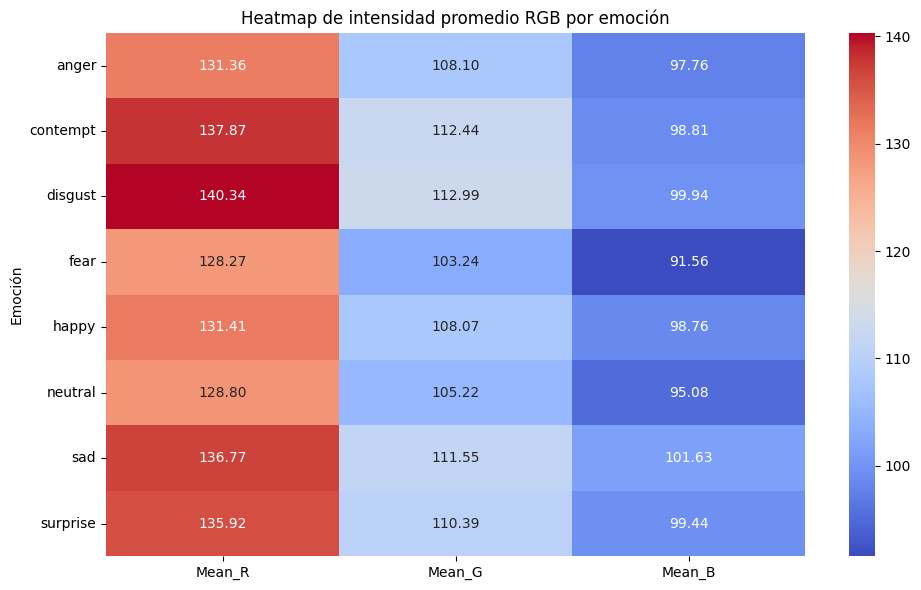

In [48]:
plt.figure(figsize=(10, 6))
sns.heatmap(tabla_rgb.set_index('Emoción')[['Mean_R', 'Mean_G', 'Mean_B']],
            annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap de intensidad promedio RGB por emoción')
plt.tight_layout()
plt.show()

C:\Users\npere\AppData\Local\Temp\ipykernel_35168\1358835680.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tabla_rgb, x='Emoción', y='Mean_RGB', palette='viridis')


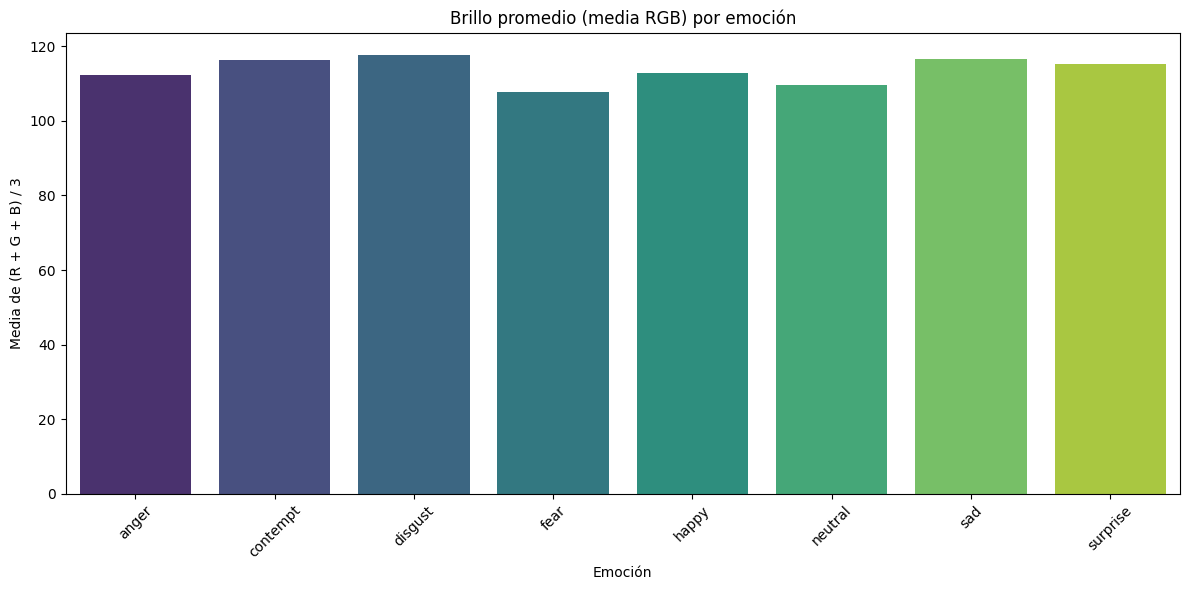

In [49]:
tabla_rgb['Mean_RGB'] = tabla_rgb[['Mean_R', 'Mean_G', 'Mean_B']].mean(axis=1)

plt.figure(figsize=(12, 6))
sns.barplot(data=tabla_rgb, x='Emoción', y='Mean_RGB', palette='viridis')
plt.title('Brillo promedio (media RGB) por emoción')
plt.ylabel('Media de (R + G + B) / 3')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [55]:
# 3. Estadísticas de color e intensidad
df['mean_R'] = df['image'].apply(lambda x: x[:, :, 0].mean())
df['mean_G'] = df['image'].apply(lambda x: x[:, :, 1].mean())
df['mean_B'] = df['image'].apply(lambda x: x[:, :, 2].mean())

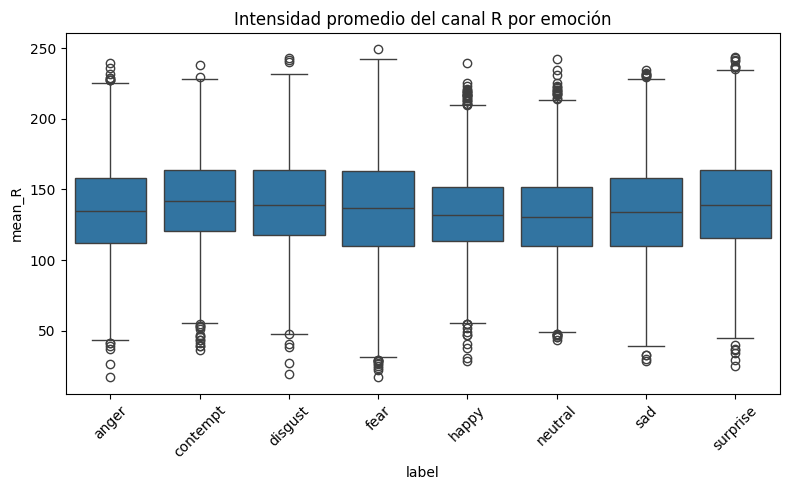

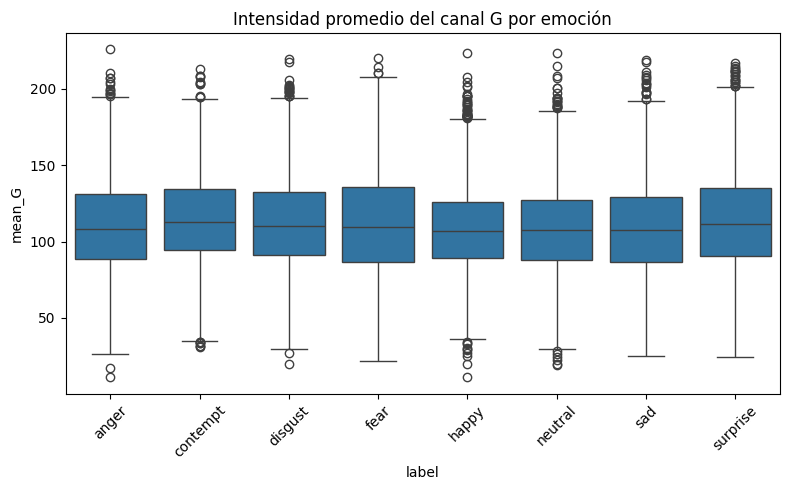

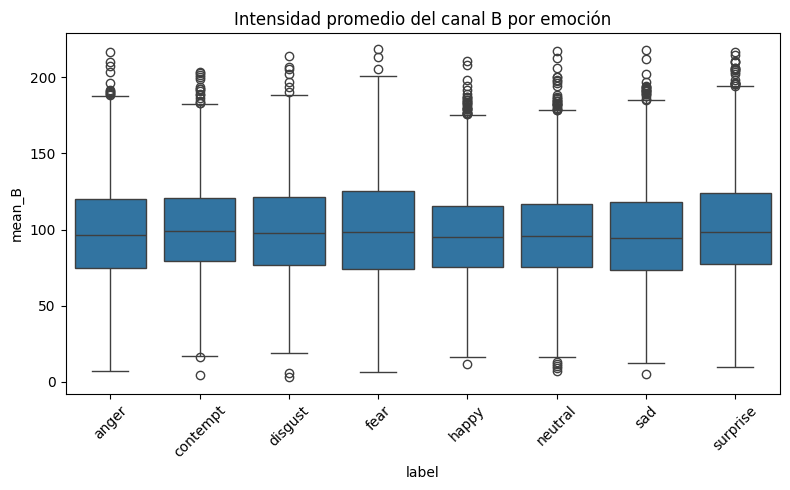

In [56]:
# Boxplots por canal
for color in ['mean_R', 'mean_G', 'mean_B']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='label', y=color)
    plt.title(f'Intensidad promedio del canal {color[-1]} por emoción')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

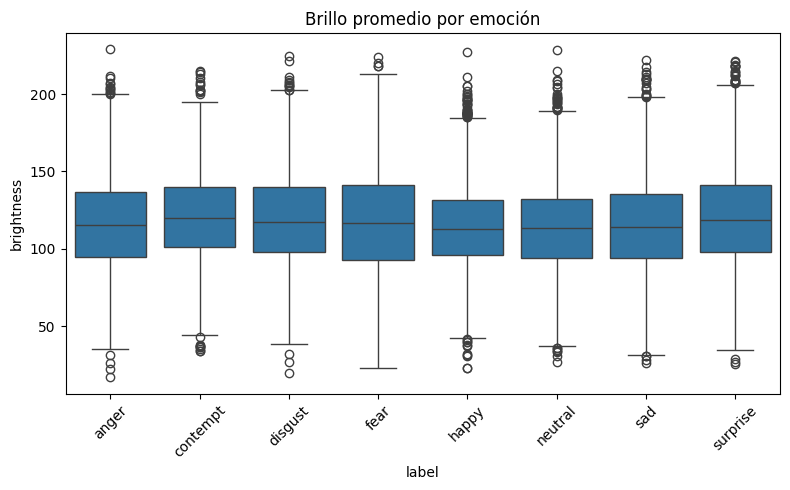

In [57]:
# 4. Brillo promedio (convertido a escala de grises)
df['brightness'] = df['image'].apply(lambda x: np.array(Image.fromarray(x).convert('L')).mean())

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='label', y='brightness')
plt.title('Brillo promedio por emoción')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [52]:
# Calcular brillo (media de grises) y nitidez (varianza del Laplaciano)
df['brightness'] = df['image'].apply(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY).mean())
df['sharpness'] = df['image'].apply(lambda x: cv2.Laplacian(cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), cv2.CV_64F).var())

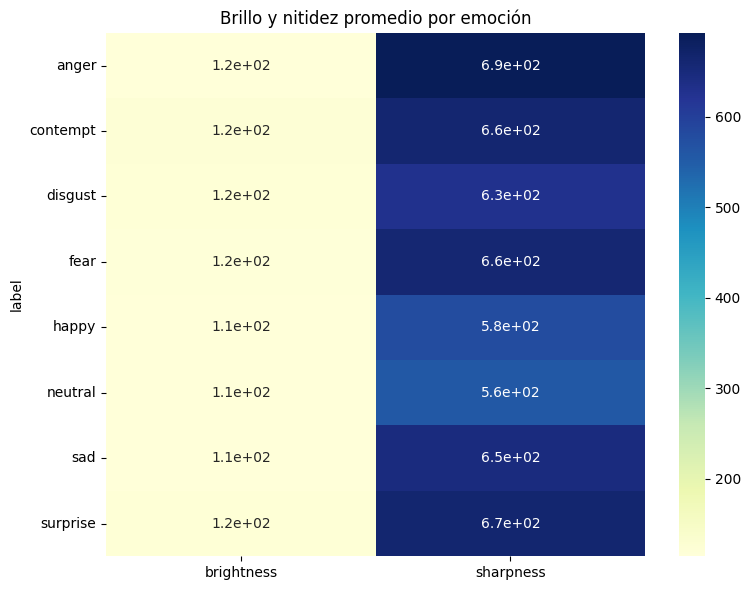

In [53]:
grupo_estadisticas = df.groupby('label')[['brightness', 'sharpness']].mean().round(2)

plt.figure(figsize=(8, 6))
sns.heatmap(grupo_estadisticas, annot=True, cmap='YlGnBu')
plt.title('Brillo y nitidez promedio por emoción')
plt.tight_layout()
plt.show()

## outliers

Número total de imágenes consideradas outliers: 3433


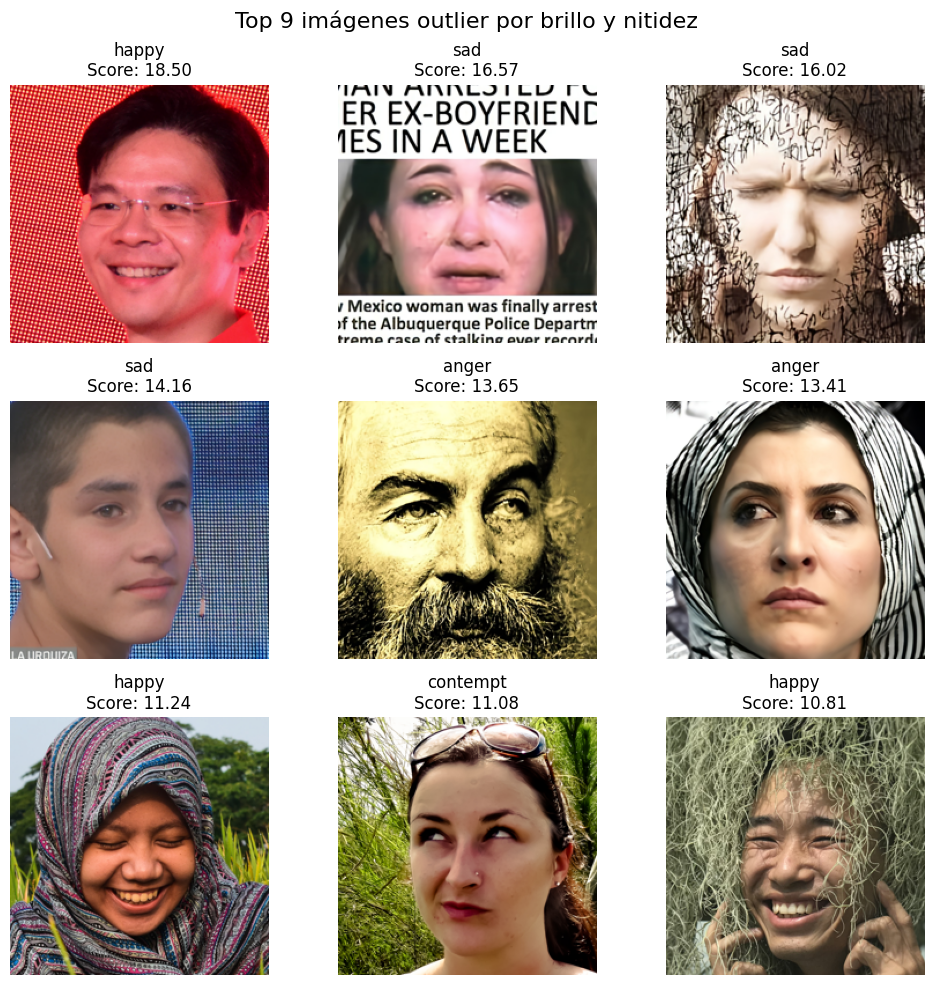

In [60]:
# Estandarizar brillo y nitidez
scaler = StandardScaler()  # Se crea un escalador para estandarizar los valores (z-score)
df[['brightness_z', 'sharpness_z']] = scaler.fit_transform(df[['brightness', 'sharpness']])
# Se aplican las transformaciones a las columnas de brillo y nitidez, creando nuevas columnas z-score

# Calcular score de outlier (distancia euclidiana al centro 0,0)
df['outlier_score'] = np.sqrt(df['brightness_z']**2 + df['sharpness_z']**2)
# Se calcula la distancia desde el punto (0,0) en el espacio brillo-nitidez estandarizado (es decir, qué tan extrema es la imagen)

# 🔎 Definir umbral para considerar outliers (por ejemplo, > 2 desviaciones)
umbral_outlier = 2  # Se define un umbral de 2 desviaciones estándar como referencia
df['is_outlier'] = df['outlier_score'] > umbral_outlier  # Marca como True las imágenes que superan ese valor

# Contar cuántas imágenes son outliers
n_outliers = df['is_outlier'].sum()  # Se cuentan cuántas tienen el flag de outlier activado
print(f"Número total de imágenes consideradas outliers: {n_outliers}")  # Se imprime el resultado

# Mostrar los 9 principales outliers
top_outliers = df[df['is_outlier']].sort_values('outlier_score', ascending=False).head(9)
# Se seleccionan las 9 imágenes con mayor score de outlier

# Visualizar
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # Se crean 9 subplots (3x3)
axes = axes.flatten()  # Se aplana el array de ejes para poder iterar más fácil

for i, (_, row) in enumerate(top_outliers.iterrows()):
    axes[i].imshow(row['image'])  # Se muestra la imagen
    axes[i].axis('off')  # Se oculta el marco
    axes[i].set_title(f"{row['label']}\nScore: {row['outlier_score']:.2f}")  # Título con etiqueta y score

plt.suptitle("Top 9 imágenes outlier por brillo y nitidez", fontsize=16)  # Título general del gráfico
plt.tight_layout()  # Ajuste automático del layout para que no se superpongan
plt.show()  # Mostrar la figura


## Guardar imágenes outliers para analisis 

In [ ]:
# Ruta base donde se guardarán las imágenes outliers
base_outlier_path = r"C:\Users\npere\OneDrive\Desktop\Universidad_La_Salle\Clases\Semestre_2\Herramientas_avanzadas_de_análisis_de_datos\Proyecto_final\results_6\outliers"
os.makedirs(base_outlier_path, exist_ok=True)

# Filtrar solo las imágenes marcadas como outliers
outlier_images = df[df['is_outlier']]

# Recorrer cada imagen outlier
for _, row in outlier_images.iterrows():
    label = row['label']             # Clase/emoción
    src_path = row['path']           # Ruta original de la imagen
    filename = os.path.basename(src_path)  # Nombre del archivo

    # Crear subcarpeta para cada emoción (si no existe)
    label_dir = os.path.join(base_outlier_path, label)
    os.makedirs(label_dir, exist_ok=True)

    # Ruta de destino final
    dst_path = os.path.join(label_dir, filename)

    # Copiar imagen a la carpeta correspondiente
    shutil.copy(src_path, dst_path)

In [ ]:
# Ruta donde se guardarán las imágenes grises detectadas
gray_dir = r"C:\Users\npere\OneDrive\Desktop\Universidad_La_Salle\Clases\Semestre_2\Herramientas_avanzadas_de_análisis_de_datos\Proyecto_final\results_6\gray_images"
os.makedirs(gray_dir, exist_ok=True)  # Crea la carpeta ya que no existe

gray_count = 0  # Contador para saber cuántas imágenes grises detectamos

# Función para detectar imágenes casi grises usando una tolerancia
def es_gris_aproximado(imagen, tolerancia=20):
    if len(imagen.shape) == 2:
        return True  # Si solo tiene 2 dimensiones, ya es escala de grises

    # Si tiene 3 canales (RGB), comparamos que los canales sean casi iguales
    if len(imagen.shape) == 3 and imagen.shape[2] == 3:
        diff_rg = np.abs(imagen[:, :, 0] - imagen[:, :, 1])
        diff_rb = np.abs(imagen[:, :, 0] - imagen[:, :, 2])
        diff_gb = np.abs(imagen[:, :, 1] - imagen[:, :, 2])
        # Si la diferencia promedio entre canales es menor que la tolerancia → es gris
        return (
            np.mean(diff_rg) < tolerancia and
            np.mean(diff_rb) < tolerancia and
            np.mean(diff_gb) < tolerancia
        )
    return False  # En otros casos, no se considera gris

# Recorremos todas las imágenes del DataFrame
for _, row in df.iterrows():
    imagen = row['image']  # Array de la imagen
    label = row['label']  # Clase/emoción
    src_path = row['path']  # Ruta original
    filename = os.path.basename(src_path)  # Nombre del archivo

    if es_gris_aproximado(imagen, tolerancia=40):  # Si la imagen es gris según la función
        gray_count += 1  # Aumenta el contador

        # Creamos la carpeta según la emoción si no existe
        label_dir = os.path.join(gray_dir, label)
        os.makedirs(label_dir, exist_ok=True)

        # Copiamos la imagen a la carpeta correspondiente
        dst_path = os.path.join(label_dir, filename)
        shutil.copy(src_path, dst_path)

# Mostramos el total de imágenes grises encontradas
print(f" Total de imágenes en escala de grises detectadas (tolerancia=40): {gray_count}")
print(f" Guardadas en: {gray_dir}")

 Total de imágenes en escala de grises detectadas (tolerancia=40): 2175
 Guardadas en: C:\Users\npere\OneDrive\Desktop\Universidad_La_Salle\Clases\Semestre_2\Herramientas_avanzadas_de_análisis_de_datos\Proyecto_final\results_6\gray_images
